# Compare EMIT and ENMAP surface reflectance

For EMIT, uses scripts adopted from Alex Leith's [hyperspectral-notebooks repo](https://github.com/auspatious/hyperspectral-notebooks/) and NASA [EMIT Resources](https://github.com/nasa/EMIT-Data-Resources/).

In [1]:
from pathlib import Path
from tools.emit_tools import emit_xarray, band_mask

In [2]:
import rioxarray as rxr
import pandas as pd
from rasterio.enums import Resampling
from matplotlib import pyplot as plt
from scipy.ndimage import binary_erosion
import numpy as np


### Load ENMAP reflectance

In [3]:
enmap_path = 'data/ENMAP/ENMAP01-____L2A-DT0000098950_20241029T005025Z_001_V010501_20241102T182123Z-SPECTRAL_IMAGE_COG.tiff'
enmap_path = 'data/ENMAP/ENMAP01-____L2A-DT0000098950_20241029T005029Z_002_V010501_20241102T182614Z-SPECTRAL_IMAGE_COG.tiff'

In [4]:
enmap_data= rxr.open_rasterio(enmap_path)

In [5]:
enmap_data

<xarray.DataArray (band: 224, y: 1183, x: 1290)> Size: 684MB
[341839680 values with dtype=int16]
Coordinates:
  * band         (band) int64 2kB 1 2 3 4 5 6 7 ... 218 219 220 221 222 223 224
  * x            (x) float64 10kB 6.314e+05 6.314e+05 ... 6.7e+05 6.7e+05
  * y            (y) float64 9kB 6.182e+06 6.182e+06 ... 6.147e+06 6.147e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0

In [6]:
enmap_wavelengths = pd.read_csv('src/enmap_wavelengths.csv')

In [7]:
enmap_wavelengths.head()

,band,cw,fwhm
0,1,418.42,7.00
1,2,424.04,6.67
2,3,429.46,6.42
3,4,434.69,6.25
4,5,439.76,6.13


### Load EMIT reflectance in ground geometry

In [8]:
rfl_path = 'data/aus/EMITL2ARFL.001/EMIT_L2A_RFL_001_20241029T023523_2430302_056/EMIT_L2A_RFL_001_20241029T023523_2430302_056.nc'

# find cooresponding mask and uncertainty files
mask_path = Path(rfl_path).parent / Path(rfl_path).name.replace('_RFL_', '_MASK_')
uncert_path = Path(rfl_path).parent / Path(rfl_path).name.replace('_RFL_', '_RFLUNCERT_')

In [9]:
# load per pixel, per wavelength mask
ds_mask = band_mask(mask_path)
# load reflectance masked 
emit_masked = emit_xarray(rfl_path, unpacked_bmask= ds_mask)

In [10]:
emit_uncert = emit_xarray(uncert_path, unpacked_bmask= ds_mask)

### Reproject ENMAP (utm) to match EMIT (lat, lon) and sample using nearest neighbor

In [11]:
enmap_reprojected = enmap_data.rio.reproject_match(emit_masked.reflectance, resampling = Resampling.nearest)
enmap_reprojected = enmap_reprojected.rename({'y':'latitude','x':'longitude'})

In [12]:
# mask for pixels with valid data
enmap_mask = (enmap_reprojected == enmap_reprojected._FillValue).mean(dim='band')<0.05

### Extract overlapping pixels

In [13]:
# Define the erosion structure (connectivity)
structure = np.ones((3, 3))  # 3x3 kernel (cross-shaped or full)

# Perform binary erosion by 10 pixels
eroded_mask = binary_erosion((emit_masked.reflectance.isnull().mean(dim='bands')<0.5).values, structure=structure, iterations=10)


In [14]:
emit_mask = (emit_masked.reflectance.isnull().mean(dim='bands')<0.05) & eroded_mask

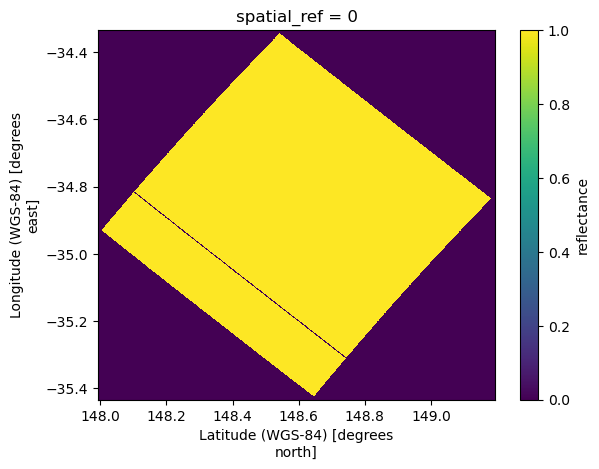

In [15]:
emit_mask.plot.imshow()

In [16]:
overlap_mask = emit_mask & enmap_mask.data

In [17]:
emit_clipped = emit_masked.reflectance.where(overlap_mask).dropna(dim='latitude', how="all").dropna(dim='longitude', how="all")
enmap_clipped = enmap_reprojected.where(overlap_mask).dropna(dim='latitude', how="all").dropna(dim='longitude', how="all")

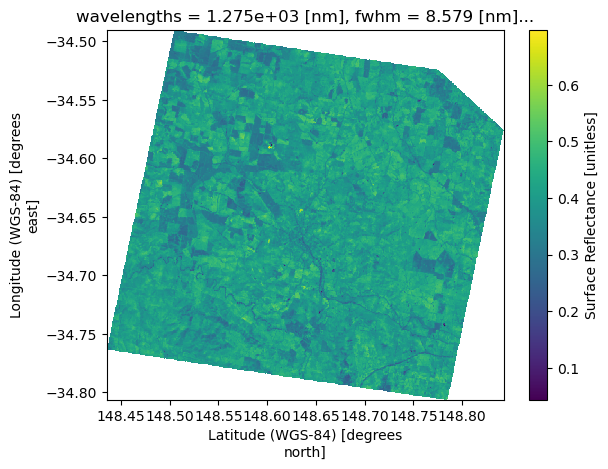

In [18]:
emit_clipped.isel(bands=120).plot.imshow()

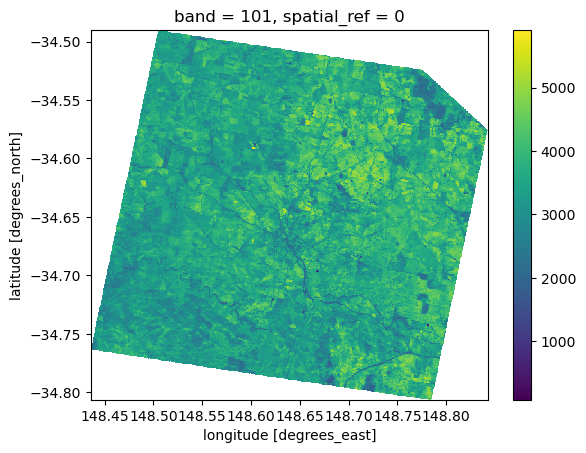

In [19]:
enmap_clipped.isel(band=100).plot.imshow()

In [20]:
emit_uncert_clipped = emit_uncert.reflectance_uncertainty.where(overlap_mask).dropna(dim='latitude', how="all").dropna(dim='longitude', how="all")

### Good wavelength range to use

In [21]:
# Define the valid wavelength ranges
ranges = [(0, 440), (1310, 1490), (1770, 2050), (2440, 2880)]

# Function to check if a wavelength is outside the valid ranges
def is_outside_range(wavelength, ranges):
    return not any(start <= wavelength <= end for start, end in ranges)

# Get the indices of the bands that fall outside the ranges
good_emit = [is_outside_range(wavelength, ranges) for wavelength in emit_clipped.bands]
good_enmap = [is_outside_range(wavelength, ranges) for wavelength in enmap_wavelengths.cw.values]

In [22]:
enmap_clipped['band'] = enmap_wavelengths.cw.values

In [23]:
emit_clipped =emit_clipped.isel(bands = good_emit)
enmap_clipped =enmap_clipped.isel(band = good_enmap)

In [24]:
emit_uncert_clipped = emit_uncert_clipped.isel(bands = good_emit)

### Classify area into three types/clusters

In [25]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import xarray as xr

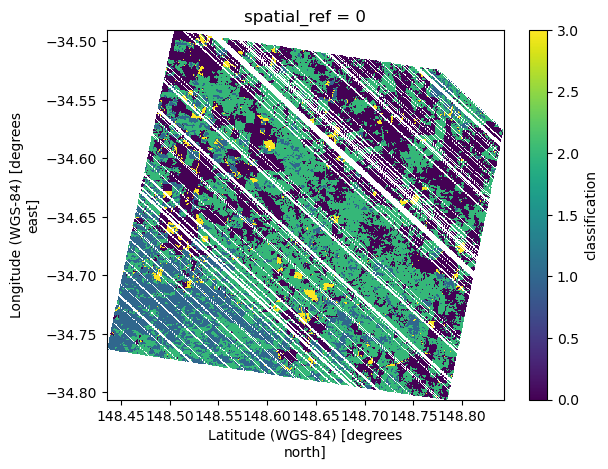

In [26]:
# Convert to (pixels, bands) format
y, x, bands = emit_clipped.shape
reshaped_data = emit_clipped.values.reshape(y*x, bands)  # (pixels, bands)
good = np.isnan(reshaped_data).mean(axis=1)==0

# Normalize the data (optional)
reshaped_data = (reshaped_data[good] - np.min(reshaped_data[good], axis=0)) / (
    np.max(reshaped_data[good], axis=0) - np.min(reshaped_data[good], axis=0) + 1e-8
)

gmm = GaussianMixture(n_components=4, random_state=42)
#kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = gmm.fit_predict(reshaped_data)

classified = np.full(y*x, -1)
classified[good] = labels

classified_image = xr.DataArray(
    classified.reshape(y,x),
    coords={"latitude": emit_clipped.latitude, "longitude": emit_clipped.longitude},
    dims=["latitude", "longitude"],
    name="classification"
    )

classified_image = classified_image.rio.write_crs(emit_clipped.rio.crs)

classified_image.where(classified_image>=0).plot.imshow()

classified_image.astype(float).rio.to_raster('overlap_classified_emit.tif', driver="GTiff")

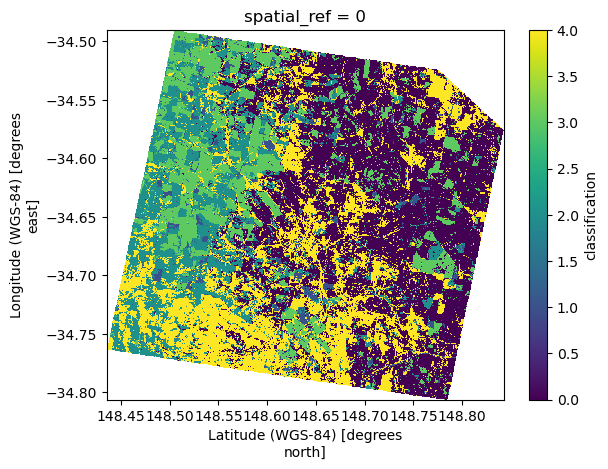

In [27]:
# Convert to (pixels, bands) format
bands, y, x = enmap_clipped.shape
reshaped_data = enmap_clipped.values.reshape(bands, y*x).T  # (pixels, bands)
good = np.isnan(reshaped_data).mean(axis=1)==0

# Normalize the data (optional)
reshaped_data = (reshaped_data[good] - np.min(reshaped_data[good], axis=0)) / (
    np.max(reshaped_data[good], axis=0) - np.min(reshaped_data[good], axis=0) + 1e-8
)

gmm = GaussianMixture(n_components=5, random_state=42)
#kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = gmm.fit_predict(reshaped_data)

classified = np.full(y*x, -1)
classified[good] = labels

classified_image = xr.DataArray(
    classified.reshape(y,x),
    coords={"latitude": emit_clipped.latitude, "longitude": emit_clipped.longitude},
    dims=["latitude", "longitude"],
    name="classification"
    )

classified_image = classified_image.rio.write_crs(emit_clipped.rio.crs)

classified_image.where(classified_image>=0).plot.imshow()

classified_image.astype(float).rio.to_raster('overlap_classified_enmap.tif', driver="GTiff")

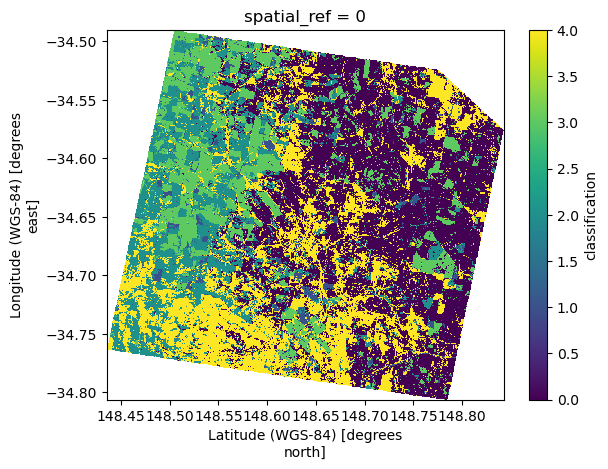

In [48]:
img = classified_image.where(classified_image>=0).plot.imshow();
colormap = img.cmap

### Sentinel-2

In [70]:
s2 = rxr.open_rasterio('data/s2/s2_20241030.nc')
s2 = s2.rio.reproject_match(emit_clipped, resampling = Resampling.nearest)
s2 = s2.squeeze().rename({'y':'latitude','x':'longitude'})

In [104]:
s2_bands = ['blue','green','red', 'red_edge_1', 'red_edge_2', 'red_edge_3', 'nir','nir_narrow', 'swir_1', 'swir_2']
s2_cw = [492., 559., 665., 704., 739., 780., 833., 864., 1610., 2186]
s2_fwhm = [65, 35, 31, 15, 13, 19, 104., 21., 94., 184.]

#### Plot mean spectra

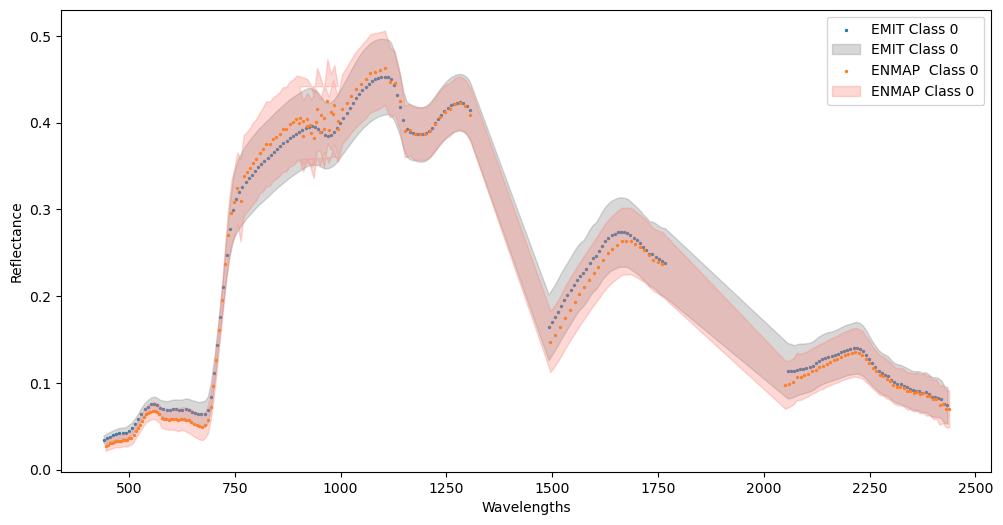

In [28]:
plt.figure(figsize=(12,6))

for class_num, style in zip([0], ['.']):

    emit_mean = emit_clipped.where(classified_image ==class_num).mean(['latitude','longitude'])
    emit_std = emit_clipped.where(classified_image ==class_num).std(['latitude','longitude'])
    enmap_mean = enmap_clipped.where(classified_image ==class_num).mean(['latitude','longitude'])/10000
    enmap_std = enmap_clipped.where(classified_image ==class_num).std(['latitude','longitude'])/10000
    
    plt.scatter(emit_mean.bands, emit_mean, label=f'EMIT Class {class_num}', marker=style, s=8)
    plt.fill_between(emit_mean.bands, emit_mean-emit_std, emit_mean+emit_std, alpha=0.3, color='gray', label=f'EMIT Class {class_num}')

    plt.scatter(enmap_mean.band, enmap_mean, label=f'ENMAP  Class {class_num}', marker=style, s=8)
    plt.fill_between(enmap_mean.band, enmap_mean-enmap_std, enmap_mean+enmap_std, alpha=0.3, color='salmon', label=f'ENMAP Class {class_num}')

    #plt.scatter(enmap_mean.band, enmap_mean.where(enmap_mean>0).where(enmap_mean.band>92)/10000, label=f'ENMAP  Class {class_num}', marker=style)
    #plt.plot(enmap_wavelengths.cw.values, enmap_mean.where(enmap_mean>0)/10000, label=f'ENMAP  Class {class_num}', linestyle=style)

plt.xlabel('Wavelengths')
plt.ylabel('Reflectance')
plt.legend()

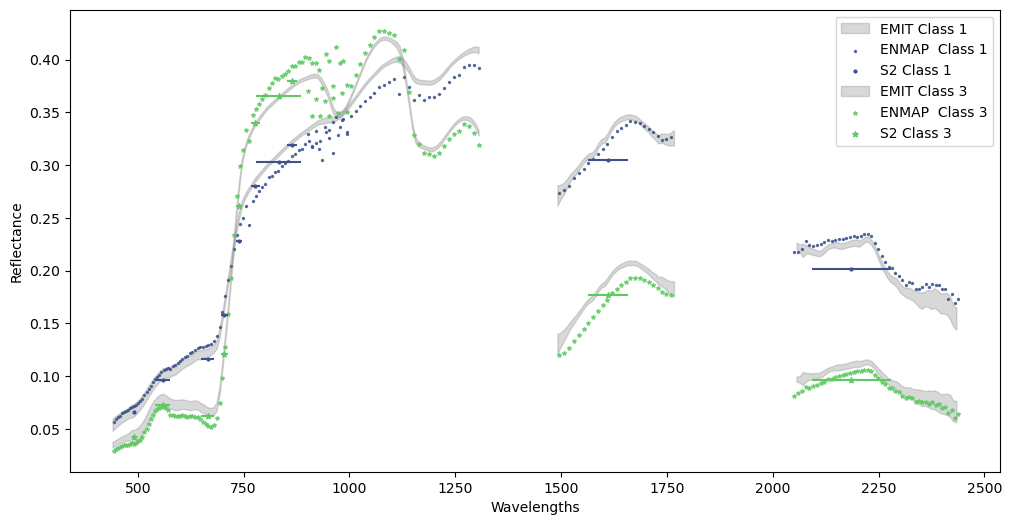

In [103]:
plt.figure(figsize=(12,6))

for class_num, style in zip([1,3], ['.','*','x', '^', 'd']):

    emit_mean_upper = emit_clipped_upper.where(classified_image ==class_num).mean(['latitude','longitude'])
    emit_mean_lower = emit_clipped_lower.where(classified_image ==class_num).mean(['latitude','longitude'])
    enmap_mean = enmap_clipped.where(classified_image ==class_num).mean(['latitude','longitude'])

    #plt.scatter(emit_mean.bands, emit_mean_upper, label=f'EMIT Class {class_num} upper', marker=style, s=8)
    #plt.scatter(emit_mean.bands, emit_mean_lower, label=f'EMIT Class {class_num} lower', marker=style, s=8)
    # Add shading between upper and lower bounds
    plt.fill_between(emit_mean.bands.where(emit_mean.bands<1310), emit_mean_lower.where(emit_mean.bands<1310), emit_mean_upper.where(emit_mean.bands<1310), alpha=0.3, color='gray', label=f'EMIT Class {class_num}')
    plt.fill_between(emit_mean.bands.where((emit_mean.bands>1490)&(emit_mean.bands<1770)), emit_mean_lower.where((emit_mean.bands>1490)&(emit_mean.bands<1770)), 
                     emit_mean_upper.where((emit_mean.bands>1490)&(emit_mean.bands<1770)), alpha=0.3, color='gray')
    plt.fill_between(emit_mean.bands.where(emit_mean.bands>2050), emit_mean_lower.where(emit_mean.bands>2050), emit_mean_upper.where(emit_mean.bands>2050), alpha=0.3, color='gray')

    plt.scatter(enmap_mean.band, enmap_mean/10000, label=f'ENMAP  Class {class_num}', marker=style, s=8, alpha=0.8, color=colormap(plt.Normalize(0, 4)(class_num)))

    for iband, band, cw, fwhm in zip(range(len(s2_bands)), s2_bands, s2_cw, s2_fwhm):
        s2_mean = s2[band].where(classified_image ==class_num).mean(['latitude','longitude'])/10000.
        if iband==0:
            plt.scatter(cw, s2_mean, marker=style, s=16, label=f'S2 Class {class_num}', color=colormap(plt.Normalize(0, 4)(class_num)))
        else:
            plt.hlines(s2_mean, xmin=cw-fwhm/2, xmax=cw+fwhm/2, color=colormap(plt.Normalize(0, 4)(class_num)))
            plt.scatter(cw, s2_mean, marker=style, s=16, color=colormap(plt.Normalize(0, 4)(class_num)))
            
        
       

plt.xlabel('Wavelengths')
plt.ylabel('Reflectance')
plt.legend()

In [30]:
emit_clipped_upper = emit_clipped+emit_uncert_clipped
emit_clipped_lower = emit_clipped-emit_uncert_clipped

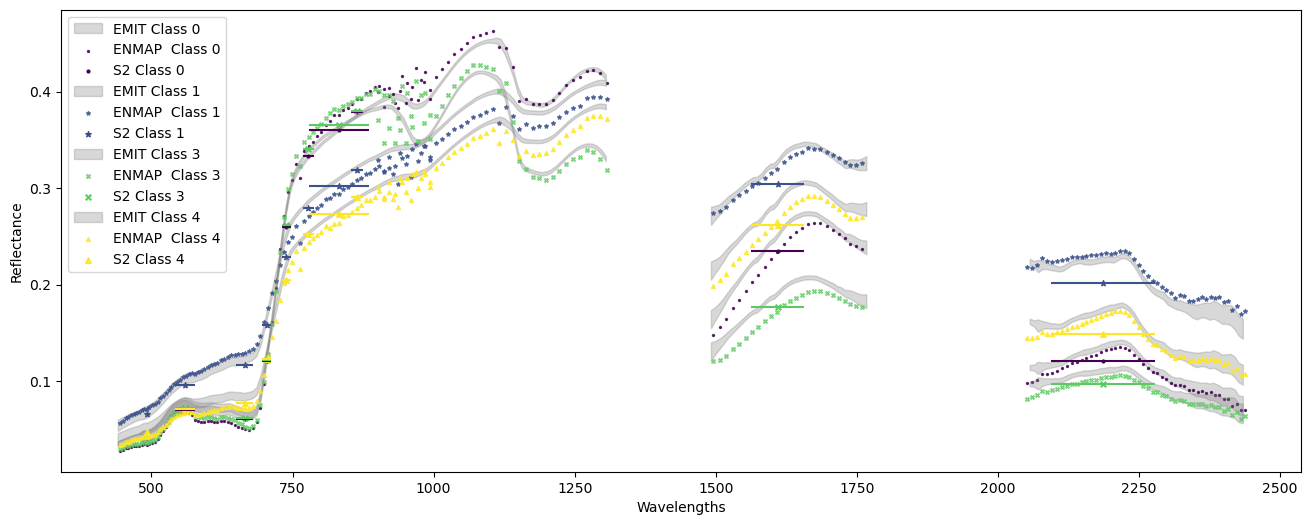

In [102]:
plt.figure(figsize=(16,6))

for class_num, style in zip([0,1,3, 4], ['.','*','x', '^', 'd']):

    emit_mean_upper = emit_clipped_upper.where(classified_image ==class_num).mean(['latitude','longitude'])
    emit_mean_lower = emit_clipped_lower.where(classified_image ==class_num).mean(['latitude','longitude'])
    enmap_mean = enmap_clipped.where(classified_image ==class_num).mean(['latitude','longitude'])

    #plt.scatter(emit_mean.bands, emit_mean_upper, label=f'EMIT Class {class_num} upper', marker=style, s=8)
    #plt.scatter(emit_mean.bands, emit_mean_lower, label=f'EMIT Class {class_num} lower', marker=style, s=8)
    # Add shading between upper and lower bounds
    plt.fill_between(emit_mean.bands.where(emit_mean.bands<1310), emit_mean_lower.where(emit_mean.bands<1310), emit_mean_upper.where(emit_mean.bands<1310), alpha=0.3, color='gray', label=f'EMIT Class {class_num}')
    plt.fill_between(emit_mean.bands.where((emit_mean.bands>1490)&(emit_mean.bands<1770)), emit_mean_lower.where((emit_mean.bands>1490)&(emit_mean.bands<1770)), 
                     emit_mean_upper.where((emit_mean.bands>1490)&(emit_mean.bands<1770)), alpha=0.3, color='gray')
    plt.fill_between(emit_mean.bands.where(emit_mean.bands>2050), emit_mean_lower.where(emit_mean.bands>2050), emit_mean_upper.where(emit_mean.bands>2050), alpha=0.3, color='gray')

    plt.scatter(enmap_mean.band, enmap_mean/10000, label=f'ENMAP  Class {class_num}', marker=style, s=8, alpha=0.8, color=colormap(plt.Normalize(0, 4)(class_num)))

    for iband, band, cw, fwhm in zip(range(len(s2_bands)), s2_bands, s2_cw, s2_fwhm):
        s2_mean = s2[band].where(classified_image ==class_num).mean(['latitude','longitude'])/10000.
        if iband==0:
            plt.scatter(cw, s2_mean, marker=style, s=16, label=f'S2 Class {class_num}', color=colormap(plt.Normalize(0, 4)(class_num)))
        else:
            plt.hlines(s2_mean, xmin=cw-fwhm/2, xmax=cw+fwhm/2, color=colormap(plt.Normalize(0, 4)(class_num)))
            plt.scatter(cw, s2_mean, marker=style, s=16, color=colormap(plt.Normalize(0, 4)(class_num)))
            
        
       

plt.xlabel('Wavelengths')
plt.ylabel('Reflectance')
plt.legend()